## Lista 2 - Lucas Carneiro

Importando e preparando os dados

In [3]:
import os

import nltk
from nltk.corpus import machado
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import PortugueseStemmer

import string

from collections import defaultdict

import matplotlib.pylab as plt2

import numpy as np
from numpy.linalg import norm

from gensim import corpora, models, similarities

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
#Organizando textos
textos = [machado.raw(id) for id in machado.fileids()]
swu = stopwords.words('portuguese') + list (string.punctuation)
stemmer = PortugueseStemmer()

textos_limpos = []
for texto in textos:
    tlimpo = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
    textos_limpos.append(tlimpo)

#Gerando coleção de textos
T = nltk.TextCollection(textos_limpos)

In [11]:
#Gerando vocabulário de palavras únicas de todos os textos
vocab = set([])
for texto in textos_limpos:
    vocab = vocab.union(set(texto))
vocab = list(vocab)

In [27]:
print(str(len(textos_limpos)) + ' textos na coleção')
print(str(len(vocab)) + ' palavras únicas na coleção')

246 textos na coleção
25980 palavras únicas na coleção


### Exercício 1

Definindo consulta

In [24]:
palavras = "ator conde cachorro"
consulta = [stemmer.stem(token.lower()) for token in WordPunctTokenizer().tokenize(palavras) if token not in swu]

Calculando valores de frequência sobre a consulta

In [38]:
#Frequência binária
bin_matrix = np.zeros((len(textos_limpos),len(consulta)))
#Frequência no texto
tf_matrix = np.zeros((len(textos_limpos),len(consulta)))
#Frequência por tf_idf
tfidf_matrix = np.zeros((len(textos_limpos),len(consulta)))

for j, termo in enumerate(consulta):
    for i, texto in enumerate(textos_limpos):
        tfidf_matrix[i,j] = T.tf_idf(termo,texto)
        tf_matrix[i,j] = T.tf(termo,texto)
        if tf_matrix[i,j] > 0:
            bin_matrix[i,j] = 1

Verificando matrizes

In [55]:
#Binário
print(bin_matrix[:3,:])
print(bin_matrix.shape)
print('\n')

#Frequência
print(tf_matrix[:3,:])
print(tf_matrix.shape)
print('\n')

#Tf_idf
print(tfidf_matrix[:3,:])
print(tfidf_matrix.shape)

[[ 0.  1.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  0.]]
(246, 3)


[[  0.00000000e+00   8.45284720e-05   2.81761573e-05]
 [  3.90731841e-05   3.51658657e-04   0.00000000e+00]
 [  2.95124543e-05   5.90249085e-05   0.00000000e+00]]
(246, 3)


[[  0.00000000e+00   1.62447882e-04   8.51039668e-05]
 [  7.96934956e-05   6.75822036e-04   0.00000000e+00]
 [  6.01934728e-05   1.13434813e-04   0.00000000e+00]]
(246, 3)


Vetorizando e ordenando valores

In [80]:
#Função de suporte
def ordem(q,MN):
    return [np.dot(q,r) for r in MN]

#Matrizes normalizadas
Mbin_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in bin_matrix])
Mtf_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tf_matrix])
Mtfidf_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in tfidf_matrix])

#Construção de vetores ordenados
vetor_tfidf = np.array([T.tf_idf(w,consulta) for w in consulta])
vetor_tfidf /= norm(vetor_tfidf)
resp_tfidf = ordem(vetor_tfidf,Mtfidf_Norm)

vetor_tf = np.array([T.tf(w,consulta) for w in consulta])
vetor_tf /= norm(vetor_tf)
resp_tf = ordem(vetor_tf,Mtf_Norm)

vetor_bin = np.ones(len(consulta))
vetor_bin /= norm(vetor_bin)
resp_bin = ordem(vetor_bin,Mbin_Norm)

vtfidf = filter(lambda x : x[0]!=0.0, zip(resp_tfidf,range(len(textos_limpos))))
vtf = filter(lambda x : x[0]!=0.0, zip(resp_tf,range(len(textos_limpos))))
vbin = filter(lambda x : x[0]!=0.0, zip(resp_bin,range(len(textos_limpos))))

#Ordenação
resposta_tfidf = sorted(vtfidf, reverse=True) 
resposta_tf = sorted(vtf, reverse=True)
resposta_bin = sorted(vbin, reverse=True)

A seguir, vamos visualizar e comparar os resultados encontrados

In [122]:
consultas_comparadas = 10

print(resposta_bin[:consultas_comparadas])
print('\n')
print(resposta_tf[:consultas_comparadas])
print('\n')
print(resposta_tfidf[:consultas_comparadas])

[(1.0000000000000002, 229), (1.0000000000000002, 227), (1.0000000000000002, 193), (1.0000000000000002, 191), (1.0000000000000002, 3), (0.81649658092772603, 231), (0.81649658092772603, 230), (0.81649658092772603, 222), (0.81649658092772603, 190), (0.81649658092772603, 187)]


[(0.92582009977255142, 3), (0.81649658092772603, 231), (0.81649658092772603, 227), (0.81649658092772603, 140), (0.81649658092772603, 85), (0.81649658092772592, 184), (0.81616352091756905, 139), (0.80064076902543568, 222), (0.78508101572886191, 185), (0.78331865189295535, 191)]


[(0.90123094742034704, 3), (0.83406585511997666, 230), (0.80040673971956733, 227), (0.75335772667895973, 0), (0.75330472343906929, 229), (0.74003315767050182, 191), (0.73307223107008035, 232), (0.73307223107008035, 219), (0.73307223107008035, 114), (0.73307223107008035, 95)]


A consulta realizada apresenta resultados parecidos entre as formas de frequência.
Mesmo que quando postos em ordem tenhamos posições diferentes, os documentos individualmente se encontram em posições próximas nos vetores.

### Exercício 2

Agora, iremos comparar como a frequência das palavras únicas se diferenciam entre os textos

In [124]:
freq_m = np.zeros((len(textos_limpos),len(vocab)))

for j, termo in enumerate(vocab):
    for i, texto in enumerate(textos_limpos):
        freq_m[i,j] = T.tf_idf(termo,texto)

Para melhor visualização normalizaremos a matrix

In [126]:
freq_Norm = np.array([r/norm(r) if norm(r) !=0 else np.zeros(len(r)) for r in freq_m])

A imagem a seguir revela como os termos se distribuem entre cada um dos textos

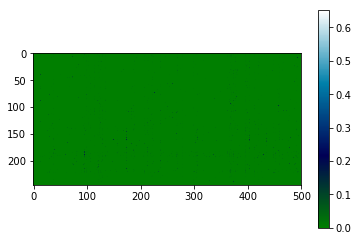

In [139]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(freq_Norm[:,:500], interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

### Exercício 3

Utilizaremos as funções do Gensim para criar um novo corpus similar ao já utilizado só que em um formato preparado para o uso das funções específicas deste pacote.

In [6]:
#Primeiro devemos gerar um 'dicionário' para as palavras únicas de forma que cada palavra tenha um id correspondente
dictionary = corpora.Dictionary(textos_limpos)

#Prosseguimos então para gerar o corpus que irá relacionar o 'id' da palavra com sua frequência no texto
#O famoso bag-of-words
corpus = [dictionary.doc2bow(text) for text in textos_limpos]

In [8]:
corpus[0][:10]

[(0, 88),
 (1, 3),
 (2, 2),
 (3, 3),
 (4, 3),
 (5, 8),
 (6, 22),
 (7, 1),
 (8, 1),
 (9, 1)]

### Exercício 4

Para gerar o modelo LSI de forma otimizada é aconselhavel utilizar o corpus gerado pelo modelo TFIDF.

In [9]:
#Construção de modelo TFIDF
mod_tfidf = models.TfidfModel(corpus)
corpus_tfidf = mod_tfidf[corpus]

#Construção de modelo LSI
mod_lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=200)
corpus_lsi = mod_lsi[corpus_tfidf] 

Com nosso modelo e corpus gerados, vamos prosseguimos para interpreta os topicos gerados

In [12]:
mod_lsi.print_topics(3)

[(0,
  '0.345*"--" + 0.272*"\x97" + 0.103*"sr" + 0.085*"poet" + 0.079*"luís" + 0.070*"..." + 0.061*"d" + 0.059*"crític" + 0.058*"camil" + 0.057*"\x93"'),
 (1,
  '-0.865*"--" + 0.244*"\x97" + -0.078*"félix" + -0.071*"helen" + -0.052*"cavalc" + -0.050*"beatriz" + -0.050*"oliv" + -0.046*"elis" + -0.043*"lalau" + -0.043*"estáci"'),
 (2,
  '-0.344*"\x97" + 0.164*"crític" + 0.154*"poet" + 0.151*"sr" + -0.133*"luís" + 0.129*"alenc" + -0.125*"--" + 0.122*"dramát" + 0.111*"poes" + 0.105*"autor"')]

Como podemos obsevar na resposta acima, ainda existem no textos alguns símbolos que podem atraplhar na análise.

Ainda assim, temos a intuição de que existe alguma relação entre os termos '--', 'x97' e 'sr' e que estes são os maiores contribuidores para determinar o quanto um texto está relacionado ao primeiro tópico.

A seguir geraremos uma pequena ilustração de quanto os 10 primeiros tópicos caracterizam o 'assunto' do primeiro texto do nosso corpus

In [15]:
corpus_lsi[0][:10]

[(0, 0.34086085378289599),
 (1, 0.14383825422506846),
 (2, -0.22083036238632733),
 (3, 0.17297770494732989),
 (4, -0.020827406056138874),
 (5, 0.058644886614146283),
 (6, -0.092818247321941036),
 (7, 0.031968217001968162),
 (8, 0.070734992840990996),
 (9, -0.1754715145991276)]

Esses valores intuem o 'assunto' do primeiro texto como uma combinação linear dos tópicos encontrados